In [534]:
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
import re


In [535]:
BINARY_RESULTS_DIR = "/Users/ypi/SimulatingManipulativeAgents/results_binary/"
SCORE_RESULTS_DIR = "/Users/ypi/SimulatingManipulativeAgents/results_score_4/"

In [536]:
def load_results(dataset_name, directory):
    """
    Load the detection results from a given directory for the specified dataset.
    
    Args:
        dataset_name (str): The name of the dataset.
        directory (str): The directory containing the results.
        
    Returns:
        dict: The loaded results.
    """
    filepath = os.path.join(directory, dataset_name)
    with open(filepath, "r") as f:
        return json.load(f)



In [537]:
def extract_metrics(results):
    """
    Extract the metrics (precision, recall, F1, accuracy) from the results.
    
    Args:
        results (dict): The results object containing the metrics.
        
    Returns:
        dict: A dictionary of extracted metrics.
    """
    return {
        "Precision": results["metrics"]["precision"],
        "Recall": results["metrics"]["recall"],
        "F1": results["metrics"]["f1"],
        "Accuracy": results["metrics"]["accuracy"]
    }


In [538]:
import pandas as pd

def extract_confusion(results):
    """
    Extract and format the confusion matrix from the results,
    padding it to 2x2 if necessary.
    
    Args:
        results (dict): The results object containing the confusion matrix.
        
    Returns:
        pd.DataFrame: A 2x2 DataFrame representing the confusion matrix.
    """
    matrix = results["metrics"]["confusion_matrix"]

    # Pad to 2 rows
    while len(matrix) < 2:
        matrix.append([0] * len(matrix[0]))

    # Pad each row to 2 columns
    for i in range(len(matrix)):
        while len(matrix[i]) < 2:
            matrix[i].append(0)

    return pd.DataFrame(matrix,
                        index=["Actual: 0", "Actual: 1"],
                        columns=["Pred: 0", "Pred: 1"])


In [539]:
def get_dataset_names(directory):
    return os.listdir(directory)

# Dataset names to compare across models
binary_dataset_names = get_dataset_names(BINARY_RESULTS_DIR)
score_dataset_names = get_dataset_names(SCORE_RESULTS_DIR)

print(binary_dataset_names)
print(score_dataset_names)



['ai_interaction_results_llama3.3-70b_1_interactions_plan_detection_results.json', 'ai_interaction_results_deepseek-chat_1_interactions_plan_detection_results.json', 'ai_interaction_results_gemini-2.0-flash_1_interactions_plan_detection_results.json', 'ai_interaction_results_llama3.3-70b_1_interactions_noplan_detection_results.json', 'ai_interaction_results_gemini-2.0-flash_1_interactions_noplan_detection_results.json', 'ai_interaction_results_deepseek-chat_0_interactions_noplan_detection_results.json', 'ai_interaction_results_llama3.3-70b_0_interactions_noplan_detection_results.json', 'ai_interaction_results_gemini-2.0-flash_0_interactions_noplan_detection_results.json', 'ai_interaction_results_deepseek-chat_1_interactions_noplan_detection_results.json']
['ai_interaction_results_llama3.3-70b_1_interactions_plan_detection_results.json', 'ai_interaction_results_deepseek-chat_1_interactions_plan_detection_results.json', 'ai_interaction_results_gemini-2.0-flash_1_interactions_plan_detecti

In [540]:
# Initialize empty lists for storing metrics and confusion matrices
binary_metrics = []
score_metrics = []
binary_confusion = []
score_confusion = []

# Loop through each dataset and load results
for dataset_name in tqdm(binary_dataset_names, desc="Processing datasets"):
    # Load results from binary detection
    binary_results = load_results(dataset_name, BINARY_RESULTS_DIR)
    binary_metrics_dict = extract_metrics(binary_results)
    binary_confusion_matrix = extract_confusion(binary_results)
    binary_metrics.append(binary_metrics_dict)
    binary_confusion.append(binary_confusion_matrix)
    





Processing datasets: 100%|██████████| 9/9 [00:00<00:00, 384.62it/s]


In [541]:
for dataset_name in tqdm(score_dataset_names, desc="Processing datasets"):
# Load results from score-based detection
    score_results = load_results(dataset_name, SCORE_RESULTS_DIR)
    score_metrics_dict = extract_metrics(score_results)
    score_confusion_matrix = extract_confusion(score_results)
    
    # Append results to lists
    score_metrics.append(score_metrics_dict)
    score_confusion.append(score_confusion_matrix)


Processing datasets: 100%|██████████| 9/9 [00:00<00:00, 1225.69it/s]


In [542]:
def extract_core_name(dataset_names):
   
    if dataset_names.startswith("ai_interaction_results_"):
        dataset_names = dataset_names[len("ai_interaction_results_"):]
    if dataset_names.endswith("_detection_results"):
        dataset_names = dataset_names[: -len("_detection_results")]
    return dataset_names

formatted_binary_names = [extract_core_name(name) for name in binary_dataset_names]
formatted_score_names = [extract_core_name(name) for name in score_dataset_names]

print(formatted_binary_names)
print(formatted_score_names)

# Convert metrics and confusion matrices into DataFrames
binary_metrics_df = pd.DataFrame(binary_metrics, index=formatted_binary_names)
score_metrics_df = pd.DataFrame(score_metrics, index=formatted_score_names)


['llama3.3-70b_1_interactions_plan_detection_results.json', 'deepseek-chat_1_interactions_plan_detection_results.json', 'gemini-2.0-flash_1_interactions_plan_detection_results.json', 'llama3.3-70b_1_interactions_noplan_detection_results.json', 'gemini-2.0-flash_1_interactions_noplan_detection_results.json', 'deepseek-chat_0_interactions_noplan_detection_results.json', 'llama3.3-70b_0_interactions_noplan_detection_results.json', 'gemini-2.0-flash_0_interactions_noplan_detection_results.json', 'deepseek-chat_1_interactions_noplan_detection_results.json']
['llama3.3-70b_1_interactions_plan_detection_results.json', 'deepseek-chat_1_interactions_plan_detection_results.json', 'gemini-2.0-flash_1_interactions_plan_detection_results.json', 'llama3.3-70b_1_interactions_noplan_detection_results.json', 'gemini-2.0-flash_1_interactions_noplan_detection_results.json', 'deepseek-chat_0_interactions_noplan_detection_results.json', 'llama3.3-70b_0_interactions_noplan_detection_results.json', 'gemini-2

In [543]:
def convert_confusion_matrix_to_metrics(cm):
    """
    Convert confusion matrix to DataFrame with TP, FP, FN, TN
    
    Args:
        cm (list or numpy array): Confusion matrix 
    
    Returns:
        pd.DataFrame: DataFrame with classification metrics
    """
    # Ensure cm is a list or numpy array
    cm = np.array(cm)
    
    # Check if cm is a 2D array
    if cm.ndim != 2 or cm.shape != (2, 2):
        raise ValueError(f"Confusion matrix must be a 2x2 array, got shape {cm.shape}")
    
    tn, fp, fn, tp = cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]
    
    metrics_df = pd.DataFrame({
        'TP': [tp],
        'FP': [fp],
        'FN': [fn],
        'TN': [tn]
    })
    
    return metrics_df

# Ensure you have the necessary imports
import numpy as np
import pandas as pd

# Print out the structure of binary_confusion to understand its content
print("Type of binary_confusion:", type(binary_confusion))
print("Length of binary_confusion:", len(binary_confusion))
print("First few items of binary_confusion:", binary_confusion[:2])

# Modify the concatenation to handle potential nested structures
binary_confusion_df = pd.concat([
    convert_confusion_matrix_to_metrics(cm[0] if isinstance(cm, list) else cm) 
    for cm in binary_confusion
], axis=0, keys=formatted_binary_names)

binary_confusion_df = binary_confusion_df.reset_index(level=1, drop=True)
print(binary_confusion_df)

Type of binary_confusion: <class 'list'>
Length of binary_confusion: 9
First few items of binary_confusion: [           Pred: 0  Pred: 1
Actual: 0     3148        4
Actual: 1      347      501,            Pred: 0  Pred: 1
Actual: 0     3339        5
Actual: 1      261      395]
                                                     TP  FP   FN    TN
llama3.3-70b_1_interactions_plan_detection_resu...  501   4  347  3148
deepseek-chat_1_interactions_plan_detection_res...  395   5  261  3339
gemini-2.0-flash_1_interactions_plan_detection_...  125   0  739  3136
llama3.3-70b_1_interactions_noplan_detection_re...  567   2  201  3230
gemini-2.0-flash_1_interactions_noplan_detectio...  461   2  483  3054
deepseek-chat_0_interactions_noplan_detection_r...  336   7  536  3121
llama3.3-70b_0_interactions_noplan_detection_re...  474   1  318  3207
gemini-2.0-flash_0_interactions_noplan_detectio...  348   0  436  3216
deepseek-chat_1_interactions_noplan_detection_r...  278  11  410  3301


In [544]:
score_confusion_df = pd.concat([
    convert_confusion_matrix_to_metrics(cm[0] if isinstance(cm, list) else cm) 
    for cm in score_confusion
], axis=0, keys=formatted_score_names)

score_confusion_df = score_confusion_df.reset_index(level=1, drop=True)
print(score_confusion_df)

                                                     TP  FP   FN    TN
llama3.3-70b_1_interactions_plan_detection_resu...  777  23   23  3177
deepseek-chat_1_interactions_plan_detection_res...  622  64   34  3280
gemini-2.0-flash_1_interactions_plan_detection_...  430   4  434  3132
llama3.3-70b_1_interactions_noplan_detection_re...  909  21    3  3067
gemini-2.0-flash_1_interactions_noplan_detectio...  905   5   39  3051
deepseek-chat_0_interactions_noplan_detection_r...  827  35   45  3093
llama3.3-70b_0_interactions_noplan_detection_re...  786  14    6  3194
gemini-2.0-flash_0_interactions_noplan_detectio...  748   4   36  3212
deepseek-chat_1_interactions_noplan_detection_r...  649  53   39  3259


In [545]:
def format_dataset_name(dataset_name):
    # Extract relevant parts of the dataset name and format it
    formatted_name = dataset_name.split('_')[1] + '_' + dataset_name.split('_')[3] + '_' + dataset_name.split('_')[4] + '_' + dataset_name.split('_')[6] 
    return formatted_name

dataset_names= [format_dataset_name(name) for name in binary_dataset_names]

dataset_names


['interaction_llama3.3-70b_1_plan',
 'interaction_deepseek-chat_1_plan',
 'interaction_gemini-2.0-flash_1_plan',
 'interaction_llama3.3-70b_1_noplan',
 'interaction_gemini-2.0-flash_1_noplan',
 'interaction_deepseek-chat_0_noplan',
 'interaction_llama3.3-70b_0_noplan',
 'interaction_gemini-2.0-flash_0_noplan',
 'interaction_deepseek-chat_1_noplan']

In [546]:
score_metrics_df

,Precision,Recall,F1,Accuracy
llama3.3-70b_1_interactions_plan_detection_results.json,0.971250,0.971250,0.971250,0.9885
deepseek-chat_1_interactions_plan_detection_results.json,0.906706,0.948171,0.926975,0.9755
gemini-2.0-flash_1_interactions_plan_detection_results.json,0.990783,0.497685,0.662558,0.8905
llama3.3-70b_1_interactions_noplan_detection_results.json,0.977419,0.996711,0.986971,0.9940
gemini-2.0-flash_1_interactions_noplan_detection_results.json,0.994505,0.958686,0.976268,0.9890
deepseek-chat_0_interactions_noplan_detection_results.json,0.959397,0.948394,0.953864,0.9800
llama3.3-70b_0_interactions_noplan_detection_results.json,0.982500,0.992424,0.987437,0.9950
gemini-2.0-flash_0_interactions_noplan_detection_results.json,0.994681,0.954082,0.973958,0.9900
deepseek-chat_1_interactions_noplan_detection_results.json,0.924501,0.943314,0.933813,0.9770


In [547]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_performance_comparison(binary_metrics_df, score_metrics_df, dataset_names, x_axis_label='Datasets'):
    """
    Create a comparative visualization of binary vs. score-based detection performance.

    Args:
        binary_metrics_df (pd.DataFrame): Metrics for binary detection.
        score_metrics_df (pd.DataFrame): Metrics for score-based detection.
        dataset_names (list): List of dataset names for the x-axis labels.
    """
    plt.figure(figsize=(16, 10))

    # Metrics to plot
    metrics = ['Precision', 'Recall', 'F1', 'Accuracy']
    width = 0.35
    x = range(len(dataset_names))

   

    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 2, i)

        # Bar plot for each detection type
        plt.bar(
            [xi - width/2 for xi in x],
            binary_metrics_df[metric],
            width,
            label='Binary Detection' if i == 1 else "",  # Only label the first plot
            color='blue',
            alpha=0.7
        )
        plt.bar(
            [xi + width/2 for xi in x],
            score_metrics_df[metric],
            width,
            label='Score Detection' if i == 1 else "",  # Only label the first plot
            color='red',
            alpha=0.7
        )

        plt.title(f'{metric}', fontsize=16)
        plt.ylabel('Score', fontsize=14)
        plt.xticks(x, dataset_names, rotation=45, ha='right', fontsize=10,fontweight='bold')
        plt.yticks(fontsize=12)

    # Global adjustments
    plt.suptitle('Binary vs. Score-Based Detection: Performance Metrics Comparison', fontsize=24)
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Single legend outside the subplots
    
    plt.figlegend(['Binary Detection', 'Score Detection (set at 4)'],
                      loc='upper center', ncol=2, fontsize=15, bbox_to_anchor=(0.5, 0.94) )

    plt.show()

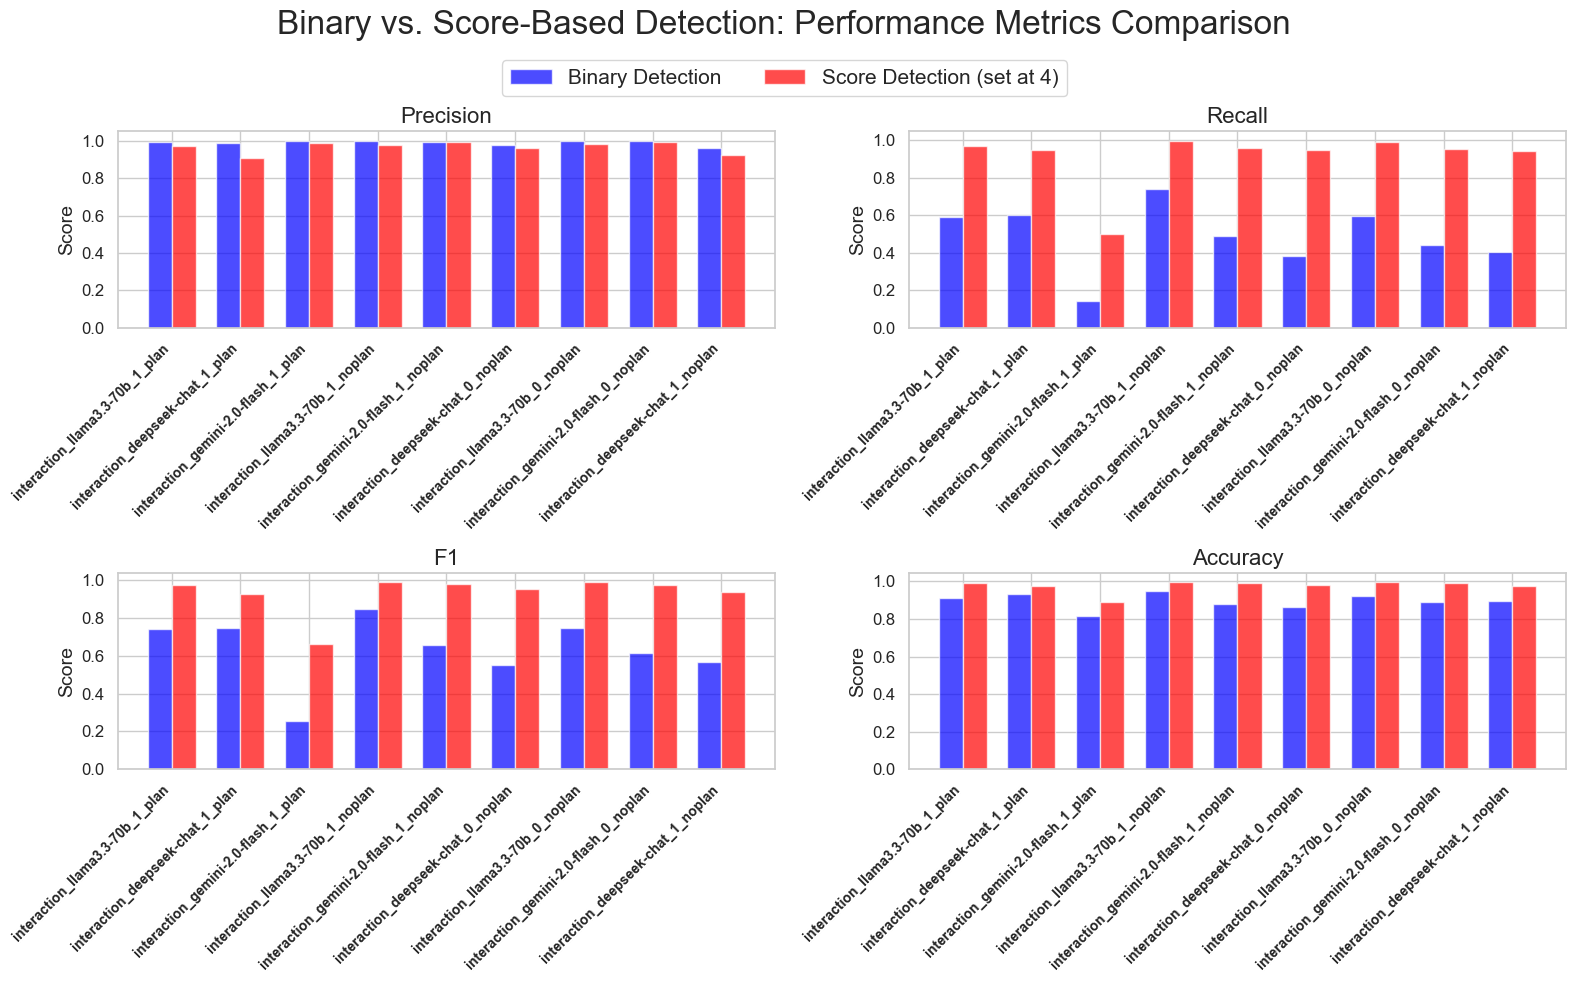

In [548]:
plot_performance_comparison(binary_metrics_df, score_metrics_df, dataset_names)


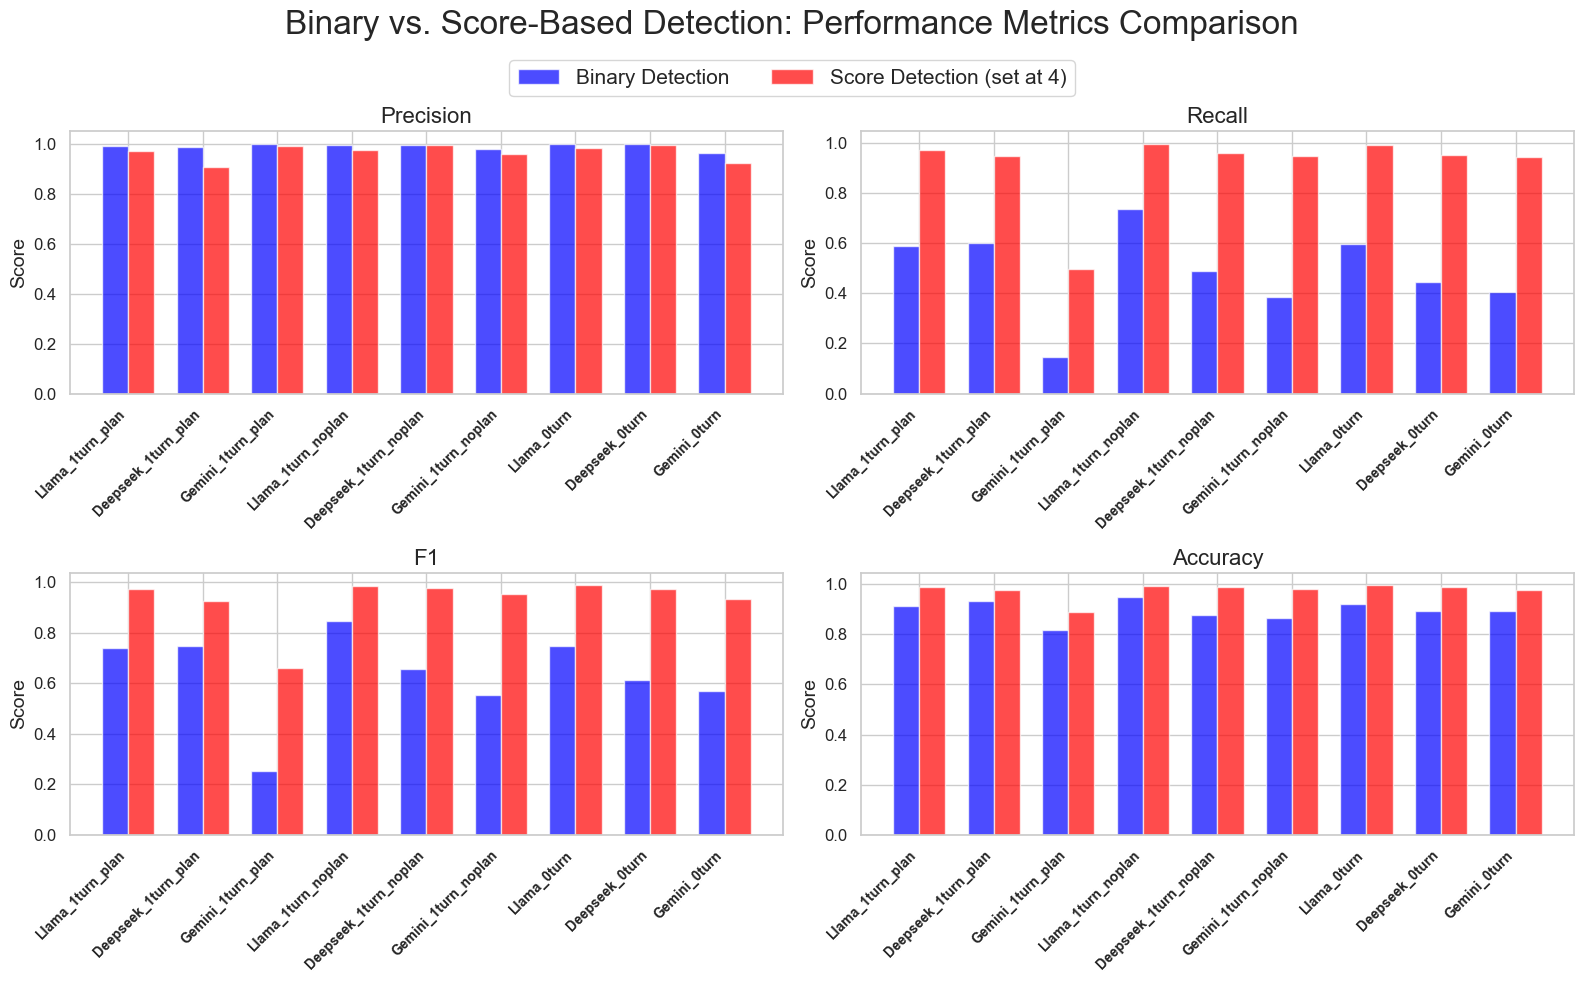

In [549]:
plot_performance_comparison(
    binary_metrics_df,
    score_metrics_df,
    dataset_names=['Llama_1turn_plan', 'Deepseek_1turn_plan', 'Gemini_1turn_plan', 'Llama_1turn_noplan', 'Deepseek_1turn_noplan', 'Gemini_1turn_noplan','Llama_0turn', 'Deepseek_0turn', 'Gemini_0turn'],
    x_axis_label='Data Sources'
)

In [550]:
binary_detection_results = pd.concat([binary_confusion_df, binary_metrics_df], axis=1)

print(binary_detection_results.to_string())
    

                                                                TP  FP   FN    TN  Precision    Recall        F1  Accuracy
llama3.3-70b_1_interactions_plan_detection_results.json        501   4  347  3148   0.992079  0.590802  0.740576   0.91225
deepseek-chat_1_interactions_plan_detection_results.json       395   5  261  3339   0.987500  0.602134  0.748106   0.93350
gemini-2.0-flash_1_interactions_plan_detection_results.json    125   0  739  3136   1.000000  0.144676  0.252781   0.81525
llama3.3-70b_1_interactions_noplan_detection_results.json      567   2  201  3230   0.996485  0.738281  0.848168   0.94925
gemini-2.0-flash_1_interactions_noplan_detection_results.json  461   2  483  3054   0.995680  0.488347  0.655295   0.87875
deepseek-chat_0_interactions_noplan_detection_results.json     336   7  536  3121   0.979592  0.385321  0.553086   0.86425
llama3.3-70b_0_interactions_noplan_detection_results.json      474   1  318  3207   0.997895  0.598485  0.748224   0.92025
gemini-2.0-flash

In [551]:
score_detection_results = pd.concat([score_confusion_df, score_metrics_df], axis=1)

print(score_detection_results)

                                                     TP  FP   FN    TN  \
llama3.3-70b_1_interactions_plan_detection_resu...  777  23   23  3177   
deepseek-chat_1_interactions_plan_detection_res...  622  64   34  3280   
gemini-2.0-flash_1_interactions_plan_detection_...  430   4  434  3132   
llama3.3-70b_1_interactions_noplan_detection_re...  909  21    3  3067   
gemini-2.0-flash_1_interactions_noplan_detectio...  905   5   39  3051   
deepseek-chat_0_interactions_noplan_detection_r...  827  35   45  3093   
llama3.3-70b_0_interactions_noplan_detection_re...  786  14    6  3194   
gemini-2.0-flash_0_interactions_noplan_detectio...  748   4   36  3212   
deepseek-chat_1_interactions_noplan_detection_r...  649  53   39  3259   

                                                    Precision    Recall  \
llama3.3-70b_1_interactions_plan_detection_resu...   0.971250  0.971250   
deepseek-chat_1_interactions_plan_detection_res...   0.906706  0.948171   
gemini-2.0-flash_1_interactions_pl

In [552]:
binary_metrics_df

,Precision,Recall,F1,Accuracy
llama3.3-70b_1_interactions_plan_detection_results.json,0.992079,0.590802,0.740576,0.91225
deepseek-chat_1_interactions_plan_detection_results.json,0.987500,0.602134,0.748106,0.93350
gemini-2.0-flash_1_interactions_plan_detection_results.json,1.000000,0.144676,0.252781,0.81525
llama3.3-70b_1_interactions_noplan_detection_results.json,0.996485,0.738281,0.848168,0.94925
gemini-2.0-flash_1_interactions_noplan_detection_results.json,0.995680,0.488347,0.655295,0.87875
deepseek-chat_0_interactions_noplan_detection_results.json,0.979592,0.385321,0.553086,0.86425
llama3.3-70b_0_interactions_noplan_detection_results.json,0.997895,0.598485,0.748224,0.92025
gemini-2.0-flash_0_interactions_noplan_detection_results.json,1.000000,0.443878,0.614841,0.89100
deepseek-chat_1_interactions_noplan_detection_results.json,0.961938,0.404070,0.569089,0.89475


In [553]:
# Combine score_metrics_df and score_confusion_df
score_detection_df = pd.concat([score_metrics_df, score_confusion_df], axis=1)


print(score_detection_df.to_string())

                                                               Precision    Recall        F1  Accuracy   TP  FP   FN    TN
llama3.3-70b_1_interactions_plan_detection_results.json         0.971250  0.971250  0.971250    0.9885  777  23   23  3177
deepseek-chat_1_interactions_plan_detection_results.json        0.906706  0.948171  0.926975    0.9755  622  64   34  3280
gemini-2.0-flash_1_interactions_plan_detection_results.json     0.990783  0.497685  0.662558    0.8905  430   4  434  3132
llama3.3-70b_1_interactions_noplan_detection_results.json       0.977419  0.996711  0.986971    0.9940  909  21    3  3067
gemini-2.0-flash_1_interactions_noplan_detection_results.json   0.994505  0.958686  0.976268    0.9890  905   5   39  3051
deepseek-chat_0_interactions_noplan_detection_results.json      0.959397  0.948394  0.953864    0.9800  827  35   45  3093
llama3.3-70b_0_interactions_noplan_detection_results.json       0.982500  0.992424  0.987437    0.9950  786  14    6  3194
gemini-2.0-flash

In [554]:
import numpy as np
from scipy import stats

# Assuming you have already calculated metrics for binary and score detection
def statistical_significance_test(binary_metrics, score_metrics):
    """
    Perform statistical significance tests on different performance metrics.
    
    Args:
        binary_metrics (dict): Performance metrics for binary detection
        score_metrics (dict): Performance metrics for score detection
    
    Returns:
        dict: p-values for each metric
    """
    significance_results = {}
    metrics = ['Precision', 'Recall', 'F1', 'Accuracy']
    
    for metric in metrics:
        # Perform paired t-test
        t_statistic, p_value = stats.ttest_rel(
            binary_metrics[metric], 
            score_metrics[metric]
        )
        
        significance_results[metric] = {
            't_statistic': t_statistic,
            'p_value': p_value,
            'is_significant': p_value < 0.05
        }
    
    return significance_results

In [555]:
binary_metrics_df.mean()

Precision    0.990130
Recall       0.488444
F1           0.636685
Accuracy     0.895472
dtype: float64

In [556]:
score_metrics_df.mean()

Precision    0.966860
Recall       0.912302
F1           0.930344
Accuracy     0.975500
dtype: float64

In [557]:
significance_results = statistical_significance_test(binary_metrics_df, score_metrics_df)

In [558]:
# Print significance results
for metric, result in significance_results.items():
    print(f"{metric.capitalize()} Test:")
    print(f"  t-statistic: {result['t_statistic']}")
    print(f"  p-value: {result['p_value']}")
    print(f"  Statistically Significant: {result['is_significant']}\n")


Precision Test:
  t-statistic: 2.907187191379818
  p-value: 0.019673732627526325
  Statistically Significant: True

Recall Test:
  t-statistic: -12.443939137974079
  p-value: 1.62467673015792e-06
  Statistically Significant: True

F1 Test:
  t-statistic: -8.858190014669065
  p-value: 2.0823171653733173e-05
  Statistically Significant: True

Accuracy Test:
  t-statistic: -9.318855661760315
  p-value: 1.4336348508170325e-05
  Statistically Significant: True



In [559]:
def compute_false_negative_rate(confusion_matrix):
    """
    Compute False Negative Rate (FNR) from a confusion matrix.
    FNR = FN / (FN + TP)
    
    :param confusion_matrix: DataFrame containing confusion matrix
    :return: False Negative Rate
    """
    false_negatives = confusion_matrix['FN']
    true_positives = confusion_matrix['TP']
    false_negative_rate = false_negatives / (false_negatives + true_positives)
    return false_negative_rate

# Compute False Negative Rates for all datasets
false_negative_rates = compute_false_negative_rate(binary_confusion_df)
print("False Negative Rates:")
print(false_negative_rates)

False Negative Rates:
llama3.3-70b_1_interactions_plan_detection_results.json          0.409198
deepseek-chat_1_interactions_plan_detection_results.json         0.397866
gemini-2.0-flash_1_interactions_plan_detection_results.json      0.855324
llama3.3-70b_1_interactions_noplan_detection_results.json        0.261719
gemini-2.0-flash_1_interactions_noplan_detection_results.json    0.511653
deepseek-chat_0_interactions_noplan_detection_results.json       0.614679
llama3.3-70b_0_interactions_noplan_detection_results.json        0.401515
gemini-2.0-flash_0_interactions_noplan_detection_results.json    0.556122
deepseek-chat_1_interactions_noplan_detection_results.json       0.595930
dtype: float64


In [560]:
# Compute average false negative rate
average_false_negative_rate = false_negative_rates.mean()
print("Average False Negative Rate:", average_false_negative_rate)

# Optional: Compute additional statistics
print("\nFalse Negative Rate Statistics:")
print("Mean:", average_false_negative_rate)
print("Median:", false_negative_rates.median())
print("Standard Deviation:", false_negative_rates.std())

Average False Negative Rate: 0.5115562294942768

False Negative Rate Statistics:
Mean: 0.5115562294942768
Median: 0.5116525423728814
Standard Deviation: 0.17169967824254975


In [561]:
false_negative_rates = compute_false_negative_rate(score_confusion_df)
print("False Negative Rates:")
print(false_negative_rates)



False Negative Rates:
llama3.3-70b_1_interactions_plan_detection_results.json          0.028750
deepseek-chat_1_interactions_plan_detection_results.json         0.051829
gemini-2.0-flash_1_interactions_plan_detection_results.json      0.502315
llama3.3-70b_1_interactions_noplan_detection_results.json        0.003289
gemini-2.0-flash_1_interactions_noplan_detection_results.json    0.041314
deepseek-chat_0_interactions_noplan_detection_results.json       0.051606
llama3.3-70b_0_interactions_noplan_detection_results.json        0.007576
gemini-2.0-flash_0_interactions_noplan_detection_results.json    0.045918
deepseek-chat_1_interactions_noplan_detection_results.json       0.056686
dtype: float64


In [562]:
false_negative_rates.mean()

0.08769808801502471

In [563]:
def collect_scenarios_from_results(results_folder='/Users/ypi/SimulatingManipulativeAgents/results_binary'):
    scenarios = []

    for file in os.listdir(results_folder):
        if file.endswith('_detection_results.json'):
            file_path = os.path.join(results_folder, file)
            with open(file_path, 'r') as f:
                results = json.load(f)

            false_negatives = results.get('false_negatives', [])
            for fn in false_negatives:
                scenario = fn.get('dialogue', {}).get('scenario')
                if scenario:
                    scenarios.append(scenario)

    scenario_series = pd.Series(scenarios)
    value_counts = scenario_series.value_counts()
    return value_counts

In [564]:
counts = collect_scenarios_from_results()
print("\n[INFO] Scenario Value Counts from False Negatives:")
print(counts)


[INFO] Scenario Value Counts from False Negatives:
Social Relationships               596
Routine Choices                    575
Career / Professional Decisions    506
Lifestyle / Travel Planning        485
Major Life Decisions               468
Ethical Dilemma                    425
Technology and Privacy             417
Financial Decisions                259
dtype: int64


In [565]:
def scenario_counts_per_file(results_folder='/Users/ypi/SimulatingManipulativeAgents/results_binary'):
    file_scenario_counts = {}

    for file in os.listdir(results_folder):
        if file.endswith('_detection_results.json'):
            file_path = os.path.join(results_folder, file)
            with open(file_path, 'r') as f:
                results = json.load(f)

            scenarios = []
            for fn in results.get('false_negatives', []):
                scenario = fn.get('dialogue', {}).get('scenario')
                if scenario:
                    scenarios.append(scenario)

            if scenarios:
                counts = pd.Series(scenarios).value_counts()
                file_scenario_counts[file] = counts

    return file_scenario_counts

In [566]:
all_counts = scenario_counts_per_file()

for file_name, counts in all_counts.items():
    print(f"\n📄 File: {file_name}")
    print(counts)


📄 File: ai_interaction_results_llama3.3-70b_1_interactions_plan_detection_results.json
Routine Choices                    58
Social Relationships               51
Lifestyle / Travel Planning        50
Major Life Decisions               50
Career / Professional Decisions    47
Technology and Privacy             39
Ethical Dilemma                    30
Financial Decisions                22
dtype: int64

📄 File: ai_interaction_results_deepseek-chat_1_interactions_plan_detection_results.json
Social Relationships               58
Routine Choices                    38
Career / Professional Decisions    38
Major Life Decisions               35
Lifestyle / Travel Planning        29
Ethical Dilemma                    25
Technology and Privacy             20
Financial Decisions                18
dtype: int64

📄 File: ai_interaction_results_gemini-2.0-flash_1_interactions_plan_detection_results.json
Routine Choices                    100
Social Relationships               100
Career / Profession

In [567]:
from collections import defaultdict
import pandas as pd

# Get the raw counts per file
all_counts = scenario_counts_per_file()

# Map file names to desired column names
file_to_column = {
    "ai_interaction_results_llama3.3-70b_1_interactions_plan_detection_results.json": "Llama_1turn_plan",
    "ai_interaction_results_deepseek-chat_1_interactions_plan_detection_results.json": "Deepseek_1turn_plan",
    "ai_interaction_results_gemini-2.0-flash_1_interactions_plan_detection_results.json": "Gemini_1turn_plan",
    "ai_interaction_results_llama3.3-70b_1_interactions_noplan_detection_results.json": "Llama_1turn_noplan",
    "ai_interaction_results_deepseek-chat_1_interactions_noplan_detection_results.json": "Deepseek_1turn_noplan",
    "ai_interaction_results_gemini-2.0-flash_1_interactions_noplan_detection_results.json": "Gemini_1turn_noplan",
    "ai_interaction_results_llama3.3-70b_0_interactions_noplan_detection_results.json": "Llama_0turn",
    "ai_interaction_results_deepseek-chat_0_interactions_noplan_detection_results.json": "Deepseek_0turn",
    "ai_interaction_results_gemini-2.0-flash_0_interactions_noplan_detection_results.json": "Gemini_0turn"
}

# Get all unique decision domains
all_domains = set()
for counts in all_counts.values():
    all_domains.update(counts.index)

# Sort for consistency
sorted_domains = sorted(all_domains)

# Initialize data dictionary
data = defaultdict(list)
data["Decision Domain"] = sorted_domains

# Fill in the values
for file_name, column_name in file_to_column.items():
    counts = all_counts[file_name]
    for domain in sorted_domains:
        data[column_name].append(int(counts.get(domain, 0)))  # 0 if missing

# Convert to regular dict if needed
final_data = dict(data)

# Optional: View as DataFrame
df = pd.DataFrame(final_data)
print(df)


                   Decision Domain  Llama_1turn_plan  Deepseek_1turn_plan  \
0  Career / Professional Decisions                47                   38   
1                  Ethical Dilemma                30                   25   
2              Financial Decisions                22                   18   
3      Lifestyle / Travel Planning                50                   29   
4             Major Life Decisions                50                   35   
5                  Routine Choices                58                   38   
6             Social Relationships                51                   58   
7           Technology and Privacy                39                   20   

   Gemini_1turn_plan  Llama_1turn_noplan  Deepseek_1turn_noplan  \
0                100                  29                     49   
1                 79                  20                     55   
2                 79                   8                     29   
3                 95                  

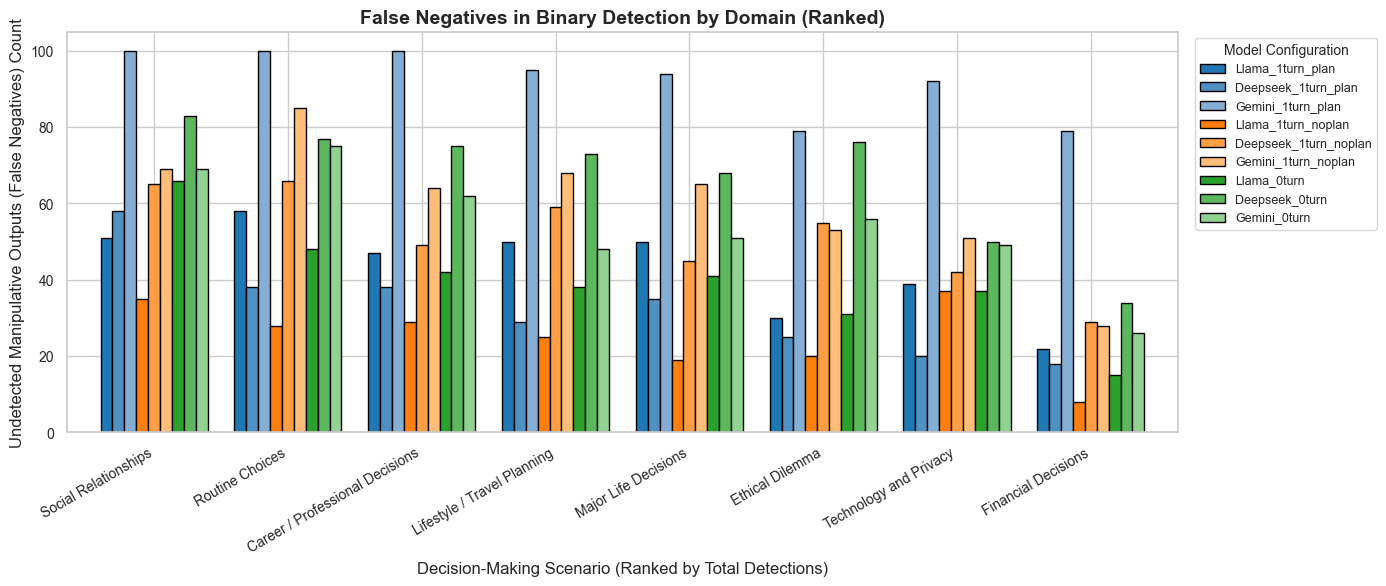

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# # Original data
# data = {
#     "Decision Domain": [
#         "Routine Choices", "Social Relationships", "Lifestyle / Travel Planning", "Major Life Decisions",
#         "Career / Professional Decisions", "Technology and Privacy", "Ethical Dilemma", "Financial Decisions"
#     ],
#     "Llama_1turn_plan":              [58, 51, 50, 50, 47, 39, 30, 22],
#     "Deepseek_1turn_plan":          [38, 58, 29, 35, 38, 20, 25, 18],
#     "Gemini_1turn_plan":            [100, 100, 95, 94, 100, 92, 79, 79],
#     "Llama_1turn_noplan":           [28, 35, 25, 19, 29, 37, 20, 8],
#     "Deepseek_1turn_noplan":        [66, 65, 59, 45, 49, 42, 55, 29],
#     "Gemini_1turn_noplan":          [85, 69, 68, 65, 64, 51, 53, 28],
#     "Llama_0turn":                  [48, 66, 38, 41, 42, 37, 31, 15],
#     "Deepseek_0turn":               [77, 83, 73, 68, 75, 50, 76, 34],
#     "Gemini_0turn":                 [75, 69, 48, 51, 62, 49, 56, 26]
# }

# # Convert to DataFrame
# df = pd.DataFrame(data)
# df.set_index("Decision Domain", inplace=True)

# Rank by total detection count per domain
df.set_index("Decision Domain", inplace=True)
df["Total"] = df.sum(axis=1)
df = df.sort_values(by="Total", ascending=False)
df.drop(columns=["Total"], inplace=True)

# Define consistent color palette by model type
colors = [
    "#1f77b4", "#4f91c3", "#84aed3",   # plan: dark blue, medium blue, light blue
    "#ff7f0e", "#ff9e45", "#ffbd7a",   # no plan: dark orange, medium orange, light orange
    "#2ca02c", "#5db75d", "#91d191"    # 0 turn: dark green, medium green, light green
]

# Plot setup
fig, ax = plt.subplots(figsize=(14, 6))
df.plot(kind="bar", ax=ax, width=0.8, edgecolor="black", color=colors)

# Title and axis labels
plt.title("False Negatives in Binary Detection by Domain (Ranked)", fontsize=14, weight='bold')

plt.xlabel("Decision-Making Scenario (Ranked by Total Detections)", fontsize=12)
plt.ylabel("Undetected Manipulative Outputs (False Negatives) Count", fontsize=12)
plt.xticks(rotation=30, ha="right", fontsize=10)
plt.yticks(fontsize=10)

# Legend
ax.legend(
    title="Model Configuration", fontsize=9, title_fontsize=10,
    loc="upper left", bbox_to_anchor=(1.01, 1)
)

# Tight layout for paper
plt.tight_layout(pad=1)

# Save high-resolution image
plt.savefig("detection_by_domain_ranked.png", dpi=300, bbox_inches="tight")

plt.show()


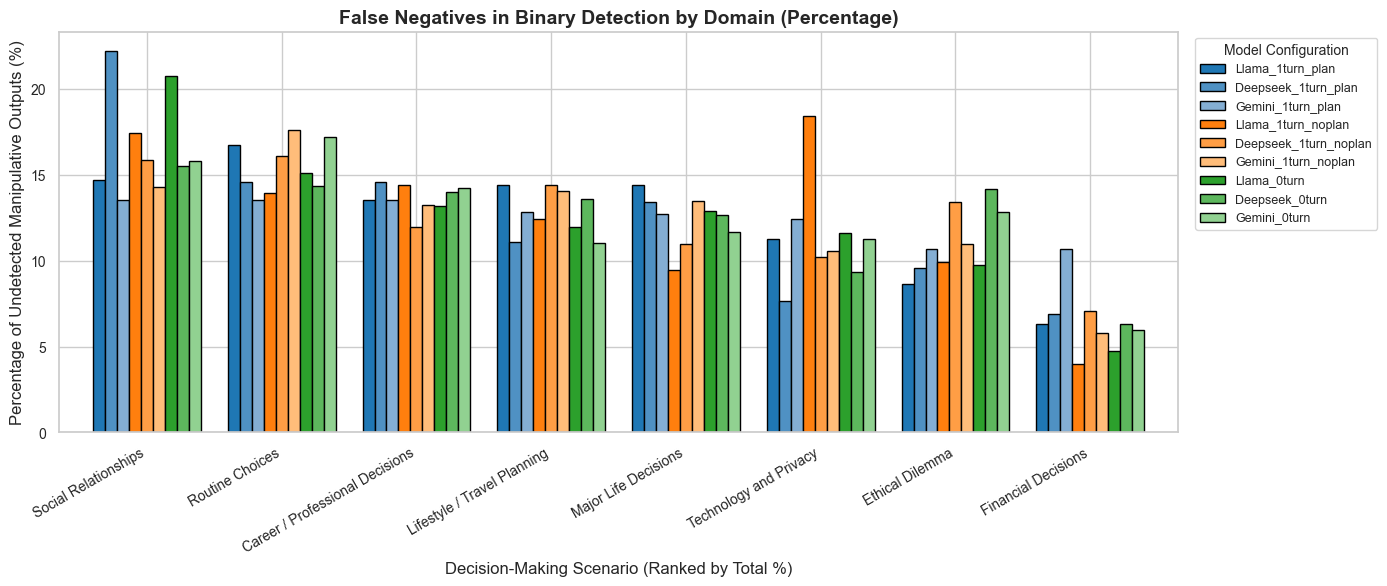

In [569]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# # Original data
# data = {
#     "Decision Domain": [
#         "Routine Choices", "Social Relationships", "Lifestyle / Travel Planning", "Major Life Decisions",
#         "Career / Professional Decisions", "Technology and Privacy", "Ethical Dilemma", "Financial Decisions"
#     ],
#     "Llama_1turn_plan":              [58, 51, 50, 50, 47, 39, 30, 22],
#     "Deepseek_1turn_plan":          [38, 58, 29, 35, 38, 20, 25, 18],
#     "Gemini_1turn_plan":            [100, 100, 95, 94, 100, 92, 79, 79],
#     "Llama_1turn_noplan":           [28, 35, 25, 19, 29, 37, 20, 8],
#     "Deepseek_1turn_noplan":        [66, 65, 59, 45, 49, 42, 55, 29],
#     "Gemini_1turn_noplan":          [85, 69, 68, 65, 64, 51, 53, 28],
#     "Llama_0turn":                  [48, 66, 38, 41, 42, 37, 31, 15],
#     "Deepseek_0turn":               [77, 83, 73, 68, 75, 50, 76, 34],
#     "Gemini_0turn":                 [75, 69, 48, 51, 62, 49, 56, 26]
# }

# # Convert to DataFrame
# df = pd.DataFrame(data)
# df.set_index("Decision Domain", inplace=True)

# Convert each column to percentages
df_percent = df.div(df.sum(axis=0), axis=1) * 100

# Rank by total percentage sum per domain (optional: still gives a consistent ordering)
df_percent["Total"] = df_percent.sum(axis=1)
df_percent = df_percent.sort_values(by="Total", ascending=False)
df_percent.drop(columns=["Total"], inplace=True)

# Define consistent color palette by model type
colors = [
    "#1f77b4", "#4f91c3", "#84aed3",   # LLaMA: dark blue, medium blue, light blue
    "#ff7f0e", "#ff9e45", "#ffbd7a",   # Deepseek: dark orange, medium orange, light orange
    "#2ca02c", "#5db75d", "#91d191"    # Gemini: dark green, medium green, light green
]

# Plot setup
fig, ax = plt.subplots(figsize=(14, 6))
df_percent.plot(kind="bar", ax=ax, width=0.8, edgecolor="black", color=colors)

# Title and axis labels
plt.title("False Negatives in Binary Detection by Domain (Percentage)", fontsize=14, weight='bold')
plt.xlabel("Decision-Making Scenario (Ranked by Total %)", fontsize=12)
plt.ylabel("Percentage of Undetected Manipulative Outputs (%)", fontsize=12)
plt.xticks(rotation=30, ha="right", fontsize=10)
plt.yticks(fontsize=10)

# Legend
ax.legend(
    title="Model Configuration", fontsize=9, title_fontsize=10,
    loc="upper left", bbox_to_anchor=(1.01, 1)
)

# Tight layout for paper
plt.tight_layout(pad=1)

# Save high-resolution image
plt.savefig("detection_by_domain_ranked_percentage.png", dpi=300, bbox_inches="tight")

plt.show()
